In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import os
from collections import OrderedDict
import sys
import copy
from pathlib import Path

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.utils import make_grid

sys.path.insert(0,'..')

import src.models.model_helpers as mh
from src.models.data_helpers import load_data, imshow, plot_image
from src.models.train_model import train_model
from src.models.predict_model import test, predict, caption_image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [13]:
torch.__version__

'1.7.0'

In [14]:
data_dir = Path('../data/raw/airlinersnet/')
models_dir = Path("../models/")
batch_size = 10
n_epochs = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
dataloaders, dataset_sizes, datasets = load_data(data_dir, batch_size)

In [16]:
import json
with open("../src/data/airlinersnet_mapping.json","r") as f:
    cat_to_name = json.load(f)

class_names = [cat_to_name[x] for x in datasets['train'].classes]

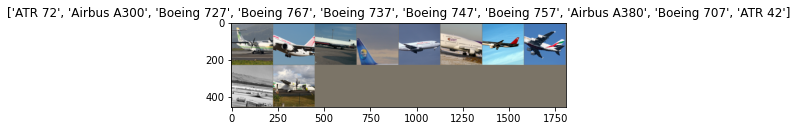

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
model = mh.initialize_model("densenet161", 1104, datasets['train'].class_to_idx, dropout=0.4, freeze_model=False)

losses = {'train': [],
          'valid': []}
acc = copy.deepcopy(losses)

In [19]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
model, optimizer, losses, acc = train_model(model, optimizer, losses, acc, dataloaders, criterion, n_epochs, device)


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 1/10..  Training Loss: 2.287..  Training Accuracy: 0.300..  Validation Loss: 1.083..  Validation Accuracy: 0.639


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 2/10..  Training Loss: 1.268..  Training Accuracy: 0.597..  Validation Loss: 0.594..  Validation Accuracy: 0.797


Steps: 100%|████████████████████████████████████████████████| 375/375 [00:57<00:00,  6.57it/s, Phase=valid, Loss=0.449]


--------
Epoch: 3/10..  Training Loss: 0.947..  Training Accuracy: 0.694..  Validation Loss: 0.449..  Validation Accuracy: 0.851


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 4/10..  Training Loss: 0.782..  Training Accuracy: 0.750..  Validation Loss: 0.501..  Validation Accuracy: 0.838


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 5/10..  Training Loss: 0.683..  Training Accuracy: 0.778..  Validation Loss: 0.311..  Validation Accuracy: 0.899


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 6/10..  Training Loss: 0.580..  Training Accuracy: 0.817..  Validation Loss: 0.336..  Validation Accuracy: 0.890


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 7/10..  Training Loss: 0.546..  Training Accuracy: 0.827..  Validation Loss: 0.237..  Validation Accuracy: 0.922


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 8/10..  Training Loss: 0.497..  Training Accuracy: 0.840..  Validation Loss: 0.231..  Validation Accuracy: 0.928


Steps:   0%|                                                                                  | 0/1124 [00:00<?, ?it/s]

--------
Epoch: 9/10..  Training Loss: 0.444..  Training Accuracy: 0.856..  Validation Loss: 0.213..  Validation Accuracy: 0.930


Steps: 100%|████████████████████████████████████████████████| 375/375 [00:43<00:00,  8.63it/s, Phase=valid, Loss=0.225]


--------
Epoch: 10/10..  Training Loss: 0.421..  Training Accuracy: 0.865..  Validation Loss: 0.225..  Validation Accuracy: 0.929


In [23]:
test(dataloaders, model, criterion, True)

Test Loss: 0.177011


Test Accuracy: 94% (3531/3749)


In [24]:
mh.save_checkpoint(models_dir, "densenet161_retrain_10_epochs", model)

In [25]:
test_path = data_dir / "test"
test_img = list(test_path.glob("*/*.jpg"))

In [29]:
predict(test_img[20], model, cat_to_name)

{'Boeing 707': 0.9140122532844543}

In [34]:
caption_image(test_img[20], model, cat_to_name, 5)

{'0': 'Boeing 707', '1': 'Boeing 717', '2': 'Boeing 727', '3': 'Boeing 737', '4': 'Boeing 747', '5': 'Boeing 757', '6': 'Boeing 767', '7': 'Boeing 777', '8': 'Boeing 787', '9': 'ATR 42', '10': 'ATR 72', '11': 'Airbus A220', '12': 'Airbus A300', '13': 'Airbus A310', '14': 'Airbus A320 Family', '15': 'Airbus A330', '16': 'Airbus A340', '17': 'Airbus A350', '18': 'Airbus A380', '19': 'Bombardier DHC-8-400', '20': 'Bombardier CRJ 200 Series', '21': 'Bombardier CRJ 700 Series', '22': 'Embraer ERJ Family', '23': 'Embraer E-Jet Family'}


TypeError: 'int' object is not subscriptable